# COVID19 conversation on Twitter

## Report Nro. XII

**Week**: 11/06/2020 - 17/06/2020. **Last update**: 18/06/2020

## Content

### **General**

- [Number of tweets and unique users](#Number-of-tweets-and-unique-users)
- [Most popular tweets](#Most-popular-tweets)

### **Tweets**

1. [Distribution of tweets by Autonoums Community](#Distribution-of-tweets-by-Autonoums-Community)
3. [Distribution of tweets by type](#Distribution-of-tweets-by-type)
4. [Distribution of tweets by type and Autonoums Community](#Distribution-of-tweets-by-type-and-Autonoums-Community)
5. [Distribution of tweets by language](#Distribution-of-tweets-by-language)
6. [Distribution of tweets by language and type](#Distribution-of-tweets-by-language-and-type)
7. [Distribution of tweets by date](#Distribution-of-tweets-by-date)
8. [Evolution of tweet types by date and time](#Distribution-of-tweets-by-day-of-the-week,-including-weekend,-and-time)
9. [Distribution of tweets by day of the week, including weekend, and time](#Distribution-of-tweets-by-day-of-the-week,-including-weekend,-and-time)
10.[Distribution of tweets by day of the week, including weekend, time, and type](#Distribution-of-tweets-by-day-of-the-week,-including-weekend,-time,-and-type)

### **Users**

1. [Distribution of unique users by date](#Distribution-of-unique-users-by-date)  
2. [Distribution of unique users by date and tweet types](#Distribution-of-unique-users-by-date-and-tweet-types)  
3. [Distribution of unique users by day of the week, including weekend, and time](#Distribution-of-unique-users-by-day-of-the-week,-including-weekend,-and-time)

### **Sentiment analysis**

1. [Sentiment evolution over time (no RTs)](#Score-sin-RTS)  
2. [Sentiment polarity evolution over time (no RTs)](#Polaridad-sin-RTS)  
3. [Sentiment polarity distribution by date (no RTs)](#Polarity)  
4. [Sentiment evolution by over time (including RTs)](#Score-con-RTs)   
5. [Sentiment polarity evolution over time (including RTs)](#Polaridad-con-RTs)   
6. [Sentiment polarity distribution by date (including RTs)](#Polarity-by-date-(including-RTs))
7. [Sentiment distribution by day of the week, including weekend, and time](#Sentimientos-por-día-semana-y-hora)

## Import dependencies

In [ ]:
import os
cwd = os.getcwd()
if cwd.split('/')[-1] != 'src':
    os.chdir('../../src')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

from datetime import date, datetime
from tqdm.notebook import tqdm
from utils.db_manager import DBManager

plt.style.use('seaborn')
sns.set_style('whitegrid')
tqdm.pandas()

/home/Life/jsaldiva/.conda/envs/twcovid/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Constant definition

In [ ]:
nro_report='12_1106170620'
# path al directorio de imagenes
report_dir = '../reports'
img_path = os.path.join(report_dir, nro_report, 'figures')
data_path = os.path.join(report_dir, nro_report, 'data')
# colores
azul_hc ='#3778BF'
celeste_int1_hc = '#539DCC'
celeste_int2_hc = '#88BEDC'
celeste_claro_hc = '#DAE8F5'
naranja_hc = '#FF7F00'
gris='gray'
# font sizes
x_labels_size = 15
y_labels_size = 15
x_ticks_size = 13
y_ticks_size = 13

## Create directory for figures

In [ ]:
if not os.path.exists(img_path):
    os.mkdir(img_path)
if not os.path.exists(data_path):
    os.mkdir(data_path)

## Get data

Get data from file otherwise from database

In [ ]:
%%time
dataset_file_name = os.path.join(data_path,'dataset_reporte_'+nro_report+'.csv')
if os.path.isfile(dataset_file_name):
    tweets_df = pd.read_csv(dataset_file_name)    
else:
    config_fn = 'config_mongo_inb.json'
    collection = 'week_11061706'
    dbm = DBManager(collection=collection, config_fn=config_fn)
    filter_query = {}
    fields_to_retrieve = {
        '_id': 0,
        'id': 1,
        'user.location':1,
        'user.screen_name': 1,
        'lang': 1,
        'sentiment.score': 1,
        'retweeted_status.id':1,
        'is_quote_status': 1,
        'in_reply_to_status_id_str': 1,
        'created_at_date': 1,
        'created_at': 1,
        'comunidad_autonoma': 1,
        'provincia': 1,
        'retweet_count': 1,
        'favorite_count': 1
    }
    data = dbm.get_tweets_reduced(filter_query,fields_to_retrieve)
    tweets_df = pd.DataFrame(data)
    data = None # free some memory

CPU times: user 36.2 s, sys: 4.86 s, total: 41.1 s
Wall time: 13min 3s


### Preliminary overview of data

In [ ]:
tweets_df.head(5)

,sentiment,type,created_at,favorite_count,id,lang,retweet_count,user_screen_name,user_location,created_at_date,comunidad_autonoma,provincia
0,0.000000,rt,Thu Jun 11 05:36:51 +0000 2020,4697,1270953120940486656,ca,2406,Shano51872812,"Queensland, Australia",2020-06-11,desconocido,desconocido
1,0.000000,rt,Thu Jun 11 12:03:21 +0000 2020,38,1271050387395612673,ca,16,lakelandruth,None,2020-06-11,desconocido,desconocido
2,0.000000,rt,Thu Jun 11 18:20:53 +0000 2020,396,1271145396581150723,ca,525,contrete78,España,2020-06-11,España,España
3,0.000000,rt,Thu Jun 11 14:19:04 +0000 2020,185,1271084541634101249,ca,168,Nachomg86,España,2020-06-11,España,España
4,0.043451,rt,Thu Jun 11 16:40:50 +0000 2020,0,1271120217708605441,ca,0,txellblanxer,Barcelona,2020-06-11,Cataluña,Barcelona


## Data processing

In [ ]:
df_columns = list(tweets_df.columns)

### Convert column created_at to datetime type

In [ ]:
%%time
if 'created_at' in df_columns:
    tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])

CPU times: user 1min 47s, sys: 7.66 ms, total: 1min 47s
Wall time: 1min 47s


### Rename column created_at_date

In [ ]:
%%time
if 'created_at_date' in df_columns:
    tweets_df['created_at_date'] = pd.to_datetime(tweets_df['created_at_date']).dt.date
    tweets_df = tweets_df.rename(columns={'created_at_date':'date'})
elif 'date' in df_columns:
    tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.date

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.4 µs


### Add column date_hour

In [ ]:
%%time
if 'date_hour' not in df_columns:
    tweets_df['date_hour'] = tweets_df['created_at'].dt.strftime('%Y-%m-%d %H')    

CPU times: user 4.39 s, sys: 7.25 ms, total: 4.39 s
Wall time: 4.4 s


In [ ]:
tweets_df.head()

,sentiment,type,created_at,favorite_count,id,lang,retweet_count,user_screen_name,user_location,date,comunidad_autonoma,provincia,date_hour,lang_org
0,0.000000,rt,2020-06-11 05:36:51+00:00,4697,1270953120940486656,ca,2406,Shano51872812,"Queensland, Australia",2020-06-11,desconocido,desconocido,2020-06-11 05,ca
1,0.000000,rt,2020-06-11 12:03:21+00:00,38,1271050387395612673,ca,16,lakelandruth,None,2020-06-11,desconocido,desconocido,2020-06-11 12,ca
2,0.000000,rt,2020-06-11 18:20:53+00:00,396,1271145396581150723,ca,525,contrete78,España,2020-06-11,España,España,2020-06-11 18,ca
3,0.000000,rt,2020-06-11 14:19:04+00:00,185,1271084541634101249,ca,168,Nachomg86,España,2020-06-11,España,España,2020-06-11 14,ca
4,0.043451,rt,2020-06-11 16:40:50+00:00,0,1271120217708605441,ca,0,txellblanxer,Barcelona,2020-06-11,Cataluña,Barcelona,2020-06-11 16,ca


### Tags of tweets written in languages not spoken in Spain

In [ ]:
languages_no_to_aggregate = ['es', 'ca', 'eu', 'gl', 'en', 'pt', 'fr', 'it']
tweets_df['lang_org'] = tweets_df['lang']
tweets_df.loc[~tweets_df.lang.isin(languages_no_to_aggregate),'lang'] = 'otro'

### Save dataset in CSV file

In [ ]:
tweets_df.to_csv(os.path.join(data_path,'dataset_reporte_'+nro_report+'.csv'), index=False)

## Number of tweets and unique users

In [ ]:
print('Nro. total de tweets: {0:,} de España'.format(tweets_df.shape[0]))

Nro. total de tweets: 657,468 de España


In [ ]:
print('Los tweets fueron publicados por {0:,} usuarios'.format(tweets_df.groupby('user_screen_name').ngroups))

Los tweets fueron publicados por 238,249 usuarios


## Most popular tweets

In [ ]:
# Class to embed tweets
class Tweet(object):
    def __init__(self, embed_str=None):
        self.embed_str = embed_str

    def _repr_html_(self):
        return self.embed_str

### The most retwitted tweet

In [ ]:
tweets_df[tweets_df['type'].isin(['og','rp','qt'])].sort_values('retweet_count', ascending=False).head(1)

,sentiment,type,created_at,favorite_count,id,lang,retweet_count,user_screen_name,user_location,date,comunidad_autonoma,provincia,date_hour,lang_org
424466,-0.007682,og,2020-06-13 12:55:19+00:00,20235,1271788239842611201,es,9982,luiscbrinol,España,2020-06-13,España,España,2020-06-13 12,es


In [ ]:
Tweet('<blockquote class="twitter-tweet"><p lang="es" dir="ltr">Nota instructiva: si &quot;accidentalmente&quot; se te caen la mascarilla o los guantes al suelo puedes, con una sencilla flexión de rodillas, agacharte, recogerlos y tirarlos a la basura. Gracias. <a href="https://t.co/gXCIl196Qj">pic.twitter.com/gXCIl196Qj</a></p>&mdash; Luis Cortés Briñol (@luiscbrinol) <a href="https://twitter.com/luiscbrinol/status/1271788239842611201?ref_src=twsrc%5Etfw">June 13, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>')

### Tweet with the largest number of favorites

In [ ]:
tweets_df[tweets_df['type'].isin(['og','rp','qt'])].sort_values('favorite_count', ascending=False).head(1)

,sentiment,type,created_at,favorite_count,id,lang,retweet_count,user_screen_name,user_location,date,comunidad_autonoma,provincia,date_hour,lang_org
340163,0.224442,qt,2020-06-12 20:56:06+00:00,31472,1271546845811146755,es,9281,galisteoaitor,"Madrid, Comunidad de Madrid",2020-06-12,Comunidad de Madrid,Madrid,2020-06-12 20,es


In [ ]:
Tweet('<blockquote class="twitter-tweet"><p lang="es" dir="ltr">Miley Cyrus mandando un tweet a Pedro Sánchez es el culmen de la simulación de este 2020 <a href="https://t.co/scLgFSlbZZ">https://t.co/scLgFSlbZZ</a></p>&mdash; Aitor 🇪🇸🏳️‍🌈 (@galisteoaitor) <a href="https://twitter.com/galisteoaitor/status/1271546845811146755?ref_src=twsrc%5Etfw">June 12, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>')

## Distribution of tweets by Autonomous Community

In [ ]:
tweets_by_group = tweets_df.groupby('comunidad_autonoma', as_index=False)['id'].count().sort_values('id', ascending=True)
tweets_by_group.loc[tweets_by_group['comunidad_autonoma']=='desconocido', 'comunidad_autonoma'] = 'Sin Localidad'

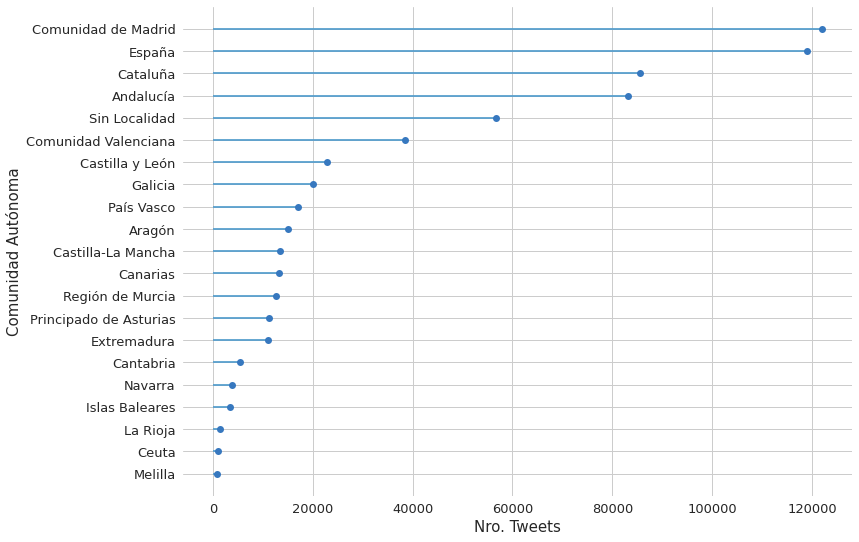

In [ ]:
plt.figure(figsize=(12,9))
fig_range=range(1,len(tweets_by_group.index)+1)
fig=plt.hlines(y=fig_range, xmin=0, xmax=tweets_by_group['id'], color='#539DCC')
plt.plot(tweets_by_group['id'], fig_range, "o", color=azul_hc)
plt.yticks(fig_range, tweets_by_group['comunidad_autonoma'])
plt.xlabel('Nro. Tweets', size=x_labels_size)
plt.ylabel('Comunidad Autónoma', size=y_labels_size)
plt.xticks(size=x_ticks_size)
plt.yticks(size=y_ticks_size)
plt.show()

In [ ]:
# save figure to file
fig.get_figure().savefig(os.path.join(img_path,"tweets_locations.png"), dpi=200, quality=95, bbox_inches="tight")

### Save table in CSV file

In [ ]:
tweets_by_group.to_csv(os.path.join(data_path,'tweets_x_ccaa.csv'), index=False)

## Explore 'unknowns'

In [ ]:
n = tweets_df[tweets_df['comunidad_autonoma']=='desconocido'].shape[0]
print(f"{n:,} tweets con comunidad autónoma desconocida")

56,773 tweets con comunidad autónoma desconocida


In [ ]:
n = tweets_df[(tweets_df['comunidad_autonoma']=='desconocido')&(tweets_df['lang'].isin(['ca','gl','eu']))].shape[0]
print(f"{n:,} tweets en catalán, gallego, vasco cuyos autores no disponen de ubicación")

53,061 tweets en catalán, gallego, vasco cuyos autores no disponen de ubicación


In [ ]:
desconocidos = tweets_df[(tweets_df['comunidad_autonoma']=='desconocido')&(~tweets_df['lang'].isin(['ca','gl','eu']))]
n = desconocidos.shape[0]
print(f"{n:,} tweets no en catalán, gallego, vasco cuyos autores no disponen de ubicación")

3,712 tweets no en catalán, gallego, vasco cuyos autores no disponen de ubicación


In [ ]:
no_location = desconocidos[desconocidos['user_location'].isna()]
print(f"{no_location.shape[0]:,} tweets cuyos autores no disponen de ubicación")

1,486 tweets cuyos autores no disponen de ubicación


In [ ]:
n = desconocidos[~desconocidos['user_location'].isna()].shape[0]
print(f"{n:,} tweets cuyos autores disponen de ubicación pero no puedieron ser clasificadas dentro de alguna comunidad autónoma")

2,226 tweets cuyos autores disponen de ubicación pero no puedieron ser clasificadas dentro de alguna comunidad autónoma


## Distribution of tweets by type


In [ ]:
tweets_by_type = tweets_df.groupby('type', as_index=False)['id'].count().sort_values('id', ascending=False)
tweets_by_type.loc[tweets_by_type['type']=='rt', 'type'] = 'Retweets'
tweets_by_type.loc[tweets_by_type['type']=='og', 'type'] = 'Originales'
tweets_by_type.loc[tweets_by_type['type']=='qt', 'type'] = 'Citas'
tweets_by_type.loc[tweets_by_type['type']=='rp', 'type'] = 'Respuestas'

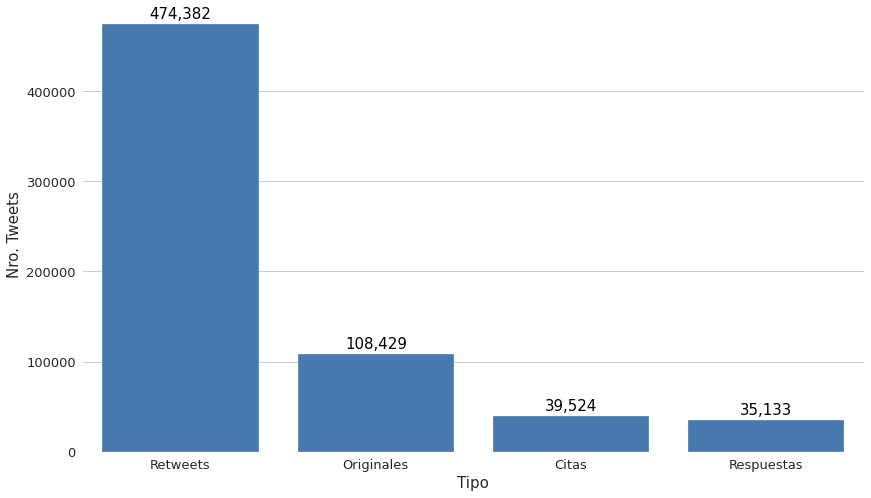

In [ ]:
plt.figure(figsize=(14,8))
fig = sns.barplot(x='type', y='id', data=tweets_by_type, color=azul_hc)
fig.set_xlabel('Tipo',fontsize=x_labels_size)
fig.set_ylabel('Nro. Tweets',fontsize=y_labels_size)
plt.xticks(size=x_ticks_size)
plt.yticks(size=y_ticks_size)
ax=fig
# Annotate bars
for p in ax.patches:
    ax.annotate("{0:,}".format(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=15, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,max(tweets_by_type['id'])+8000) #To make space for the annotations
plt.show()

In [ ]:
# save figure to file
fig.get_figure().savefig(os.path.join(img_path, "tweets_type.png"), dpi=200, quality=95, bbox_inches="tight")

In [ ]:
dist_types = tweets_by_type['id']/tweets_by_type['id'].sum()
dist_types_list = list(round(100*dist_types,1))
dist_types_list.sort(reverse=True)

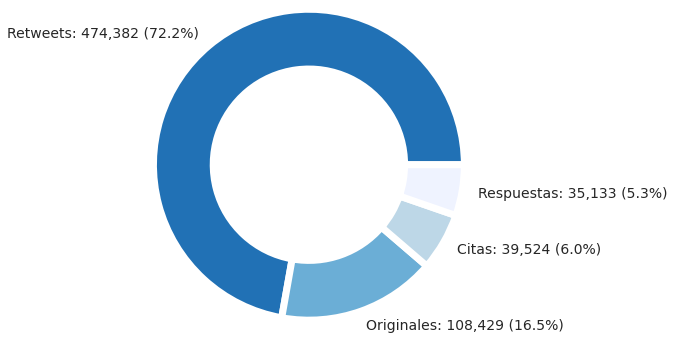

In [ ]:
from palettable.colorbrewer.sequential import Blues_4_r

group_names=['Retweets: {0:,} ({1}%)'.format(tweets_by_type.iloc[0]['id'], str(dist_types_list[0])), 
             'Originales: {0:,} ({1}%)'.format(tweets_by_type.iloc[1]['id'], str(dist_types_list[1])), 
             'Citas: {0:,} ({1}%)'.format(tweets_by_type.iloc[2]['id'], str(dist_types_list[2])),
             'Respuestas: {0:,} ({1}%)'.format(tweets_by_type.iloc[3]['id'], str(dist_types_list[3]))
            ]
group_size=dist_types_list
fig, ax = plt.subplots()
ax.axis('equal')
pie, _ = ax.pie(group_size, radius=1.3, labels=group_names, 
                wedgeprops = {'linewidth' : 7, 'edgecolor' : 'white'},
                textprops={'fontsize': 14},
                colors=Blues_4_r.hex_colors)
plt.setp(pie, width=0.5, edgecolor='white')
plt.show()

In [ ]:
# save figure to file
ax.get_figure().savefig(os.path.join(img_path, "tweets_type_donut.png"), dpi=200, quality=95, bbox_inches="tight")

### Save table in CSV file

In [ ]:
tweets_by_type.to_csv(os.path.join(data_path,'tweets_x_type.csv'), index=False)

## Distribución of tweets by type and Autonoums Community

In [ ]:
tweets_by_type = tweets_df.groupby(['comunidad_autonoma','type'], as_index=False)['id'].count().sort_values('comunidad_autonoma', ascending=True)
tweets_by_type.loc[tweets_by_type['type']=='rt', 'type'] = 'Retweets'
tweets_by_type.loc[tweets_by_type['type']=='og', 'type'] = 'Originales'
tweets_by_type.loc[tweets_by_type['type']=='qt', 'type'] = 'Citas'
tweets_by_type.loc[tweets_by_type['type']=='rp', 'type'] = 'Respuestas'

In [ ]:
tweets_type_by_ccaa = tweets_by_type.pivot(columns='type', values='id', index='comunidad_autonoma')

In [ ]:
tweets_type_by_ccaa['Total'] = tweets_type_by_ccaa['Citas']+tweets_type_by_ccaa['Originales']+tweets_type_by_ccaa['Respuestas']+tweets_type_by_ccaa['Retweets']
tweets_type_by_ccaa['Prop. Citas'] = tweets_type_by_ccaa['Citas']/tweets_type_by_ccaa['Total']
tweets_type_by_ccaa['Prop. Originales'] = tweets_type_by_ccaa['Originales']/tweets_type_by_ccaa['Total']
tweets_type_by_ccaa['Prop. Respuestas'] = tweets_type_by_ccaa['Respuestas']/tweets_type_by_ccaa['Total']
tweets_type_by_ccaa['Prop. Retweets'] = tweets_type_by_ccaa['Retweets']/tweets_type_by_ccaa['Total']

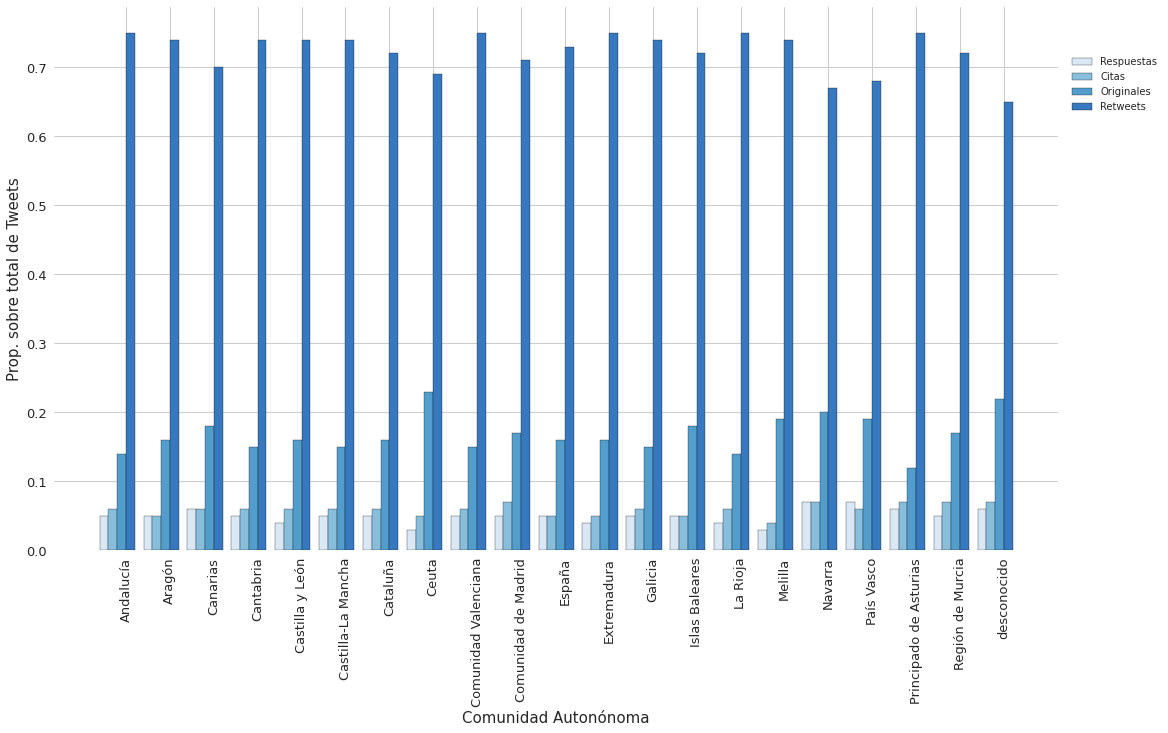

In [ ]:
fig, ax = plt.subplots(figsize=(18,10))

# width of the bars
barWidth = 0.2
 
# height of bars
org_bars = round(tweets_type_by_ccaa['Prop. Originales'],2)
rts_bars = round(tweets_type_by_ccaa['Prop. Retweets'],2)
rps_bars = round(tweets_type_by_ccaa['Prop. Respuestas'],2)
qts_bars = round(tweets_type_by_ccaa['Prop. Citas'],2)
 
# The x position of bars
r1 = np.arange(len(rps_bars))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Create reply bars
rp_rects = plt.bar(r1, rps_bars, width=barWidth, color=celeste_claro_hc, edgecolor='black', capsize=7, label='Respuestas')
# Create quote bars
qt_rects = plt.bar(r2, qts_bars, width=barWidth, color =celeste_int2_hc, edgecolor='black', capsize=7, label='Citas')
# Create original bars
or_rects = plt.bar(r3, org_bars, width=barWidth, color =celeste_int1_hc, edgecolor='black', capsize=7, label='Originales')
# Create retweet bars
rt_rects = plt.bar(r4, rts_bars, width=barWidth, color=azul_hc, edgecolor='black', capsize=7, label='Retweets')

# general layout
plt.xticks([r + barWidth + 0.3 for r in range(len(rps_bars))], tweets_type_by_ccaa.index, size=x_ticks_size, rotation=90)
plt.yticks(size=x_ticks_size)
plt.ylabel('Prop. sobre total de Tweets', fontsize=x_labels_size)
plt.xlabel('Comunidad Autonónoma', fontsize=y_labels_size)
plt.legend(loc=(1.01,0.8))


# Show graphic
plt.show()

In [ ]:
# save figure to file
fig.savefig(os.path.join(img_path, "tweets_type_ccaa.png"), dpi=200, quality=95, bbox_inches="tight")

### Save table in CVS file

In [ ]:
tweets_type_by_ccaa.to_csv(os.path.join(data_path,'tweets_x_type_x_ccaa.csv'), index=False)

## Distribution of tweets by language

In [ ]:
tweets_by_group = tweets_df.groupby('lang', as_index=False)['id'].count().sort_values('id', ascending=False)
tweets_by_group.loc[tweets_by_group['lang']=='es', 'lang'] = 'Español'
tweets_by_group.loc[tweets_by_group['lang']=='ca', 'lang'] = 'Catalán'
tweets_by_group.loc[tweets_by_group['lang']=='eu', 'lang'] = 'Euskera'
tweets_by_group.loc[tweets_by_group['lang']=='gl', 'lang'] = 'Gallego'
tweets_by_group.loc[tweets_by_group['lang']=='en', 'lang'] = 'Inglés'
tweets_by_group.loc[tweets_by_group['lang']=='pt', 'lang'] = 'Portugues'
tweets_by_group.loc[tweets_by_group['lang']=='fr', 'lang'] = 'Francés'
tweets_by_group.loc[tweets_by_group['lang']=='it', 'lang'] = 'Italiano'
tweets_by_group.loc[tweets_by_group['lang']=='otro', 'lang'] = 'Otro'

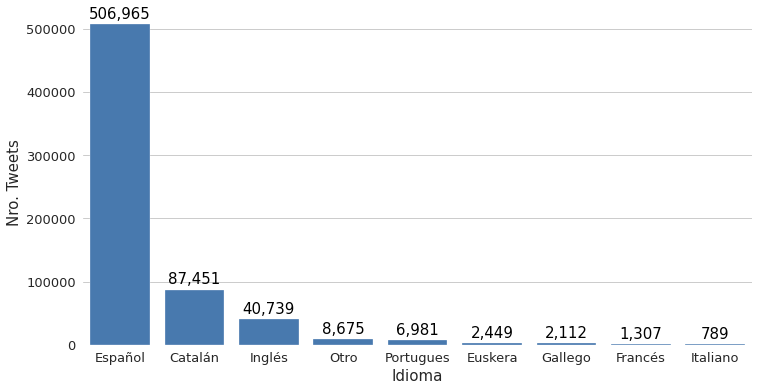

In [ ]:
plt.figure(figsize=(12,6))
fig = sns.barplot(x='lang', y='id', data=tweets_by_group, color=azul_hc)
fig.set_xlabel('Idioma',fontsize=x_labels_size)
fig.set_ylabel('Nro. Tweets',fontsize=y_labels_size)
plt.xticks(size=x_ticks_size)
plt.yticks(size=y_ticks_size)
ax=fig
# Annotate bars
for p in ax.patches:
    ax.annotate("{0:,}".format(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=15, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,max(tweets_by_group['id'])+9000) #To make space for the annotations
plt.show()

In [ ]:
# save figure to file
fig.get_figure().savefig(os.path.join(img_path, "tweets_langs.png"), dpi=200, quality=95, bbox_inches="tight")

In [ ]:
dist_langs = tweets_by_group['id']/tweets_by_type['id'].sum()
dist_langs = list(round(100*dist_langs,1))
dist_langs.sort(reverse=True)

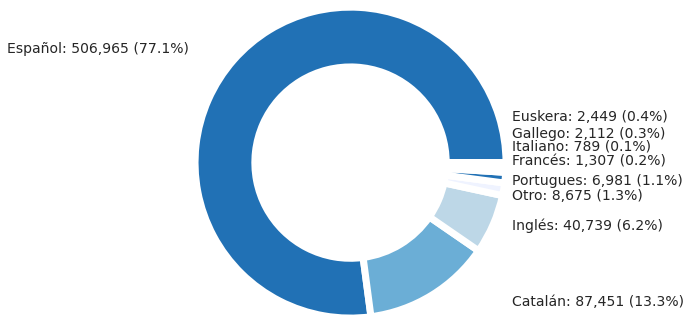

In [ ]:
from palettable.colorbrewer.sequential import Blues_4_r

group_names = []
for i, val in enumerate(dist_langs):
    group_names.append(
        '{0}: {1:,} ({2}%)'.format(tweets_by_group.iloc[i]['lang'], tweets_by_group.iloc[i]['id'], str(val))
    )
    
group_size=dist_langs

fig, ax = plt.subplots()
ax.axis('equal')

#wedges, texts = ax.pie(group_size, radius=1.3, labels=group_names, 
#                       wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
#                       textprops={'fontsize': 14},
#                       colors=Blues_4_r.hex_colors)

wedges, texts = ax.pie(group_size, radius=1.3, wedgeprops={'width': 0.5, 'linewidth' : 7, 'edgecolor' : 'white'}, 
                       colors=Blues_4_r.hex_colors)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),bbox=bbox_props, zorder=5, va="center", fontsize=14, color='black')

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    if 'Euskera' in group_names[i]:
        y += 0.30
    if 'Gallego' in group_names[i]:
        y += 0.18
    if 'Portugues' in group_names[i]:
        y -= 0.03
    if 'Italiano' in group_names[i]:
        y += 0.08
    if 'Frances' in group_names[i]:
        y += 0.02
    if 'Otro' in group_names[i]:
        y -= 0.05
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    #kw["fontsize"].update({"fontsize": 14})
    #kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(group_names[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **{'fontsize': 14})

#plt.setp(pie, width=0.3, edgecolor='white')
plt.show()

In [ ]:
# save figure to file
ax.get_figure().savefig(os.path.join(img_path, "tweets_langs_donut.png"), dpi=200, quality=95, bbox_inches="tight")

### Save table in CSV file

In [ ]:
tweets_by_group.to_csv(os.path.join(data_path,'tweets_x_langs.csv'), index=False)

## Distribution of tweets by language and type

In [ ]:
tweets_by_type = tweets_df.groupby(['lang','type'], as_index=False)['id'].count().sort_values('lang', ascending=True)
tweets_by_type.loc[tweets_by_type['type']=='rt', 'type'] = 'Retweets'
tweets_by_type.loc[tweets_by_type['type']=='og', 'type'] = 'Originales'
tweets_by_type.loc[tweets_by_type['type']=='qt', 'type'] = 'Citas'
tweets_by_type.loc[tweets_by_type['type']=='rp', 'type'] = 'Respuestas'
tweets_by_type.loc[tweets_by_type['lang']=='es', 'lang'] = 'Español'
tweets_by_type.loc[tweets_by_type['lang']=='ca', 'lang'] = 'Catalán'
tweets_by_type.loc[tweets_by_type['lang']=='eu', 'lang'] = 'Euskera'
tweets_by_type.loc[tweets_by_type['lang']=='gl', 'lang'] = 'Gallego'
tweets_by_type.loc[tweets_by_type['lang']=='en', 'lang'] = 'Inglés'
tweets_by_type.loc[tweets_by_type['lang']=='pt', 'lang'] = 'Portugues'
tweets_by_type.loc[tweets_by_type['lang']=='it', 'lang'] = 'Italiano'
tweets_by_type.loc[tweets_by_type['lang']=='fr', 'lang'] = 'Frances'
tweets_by_type.loc[tweets_by_type['lang']=='otro', 'lang'] = 'Otro'

In [ ]:
tweets_type_by_lang = tweets_by_type.pivot(columns='type', values='id', index='lang')

In [ ]:
tweets_type_by_lang['Total'] = tweets_type_by_lang['Citas']+tweets_type_by_lang['Originales']+tweets_type_by_lang['Respuestas']+tweets_type_by_lang['Retweets']
tweets_type_by_lang['Prop. Citas'] = tweets_type_by_lang['Citas']/tweets_type_by_lang['Total']
tweets_type_by_lang['Prop. Originales'] = tweets_type_by_lang['Originales']/tweets_type_by_lang['Total']
tweets_type_by_lang['Prop. Respuestas'] = tweets_type_by_lang['Respuestas']/tweets_type_by_lang['Total']
tweets_type_by_lang['Prop. Retweets'] = tweets_type_by_lang['Retweets']/tweets_type_by_lang['Total']

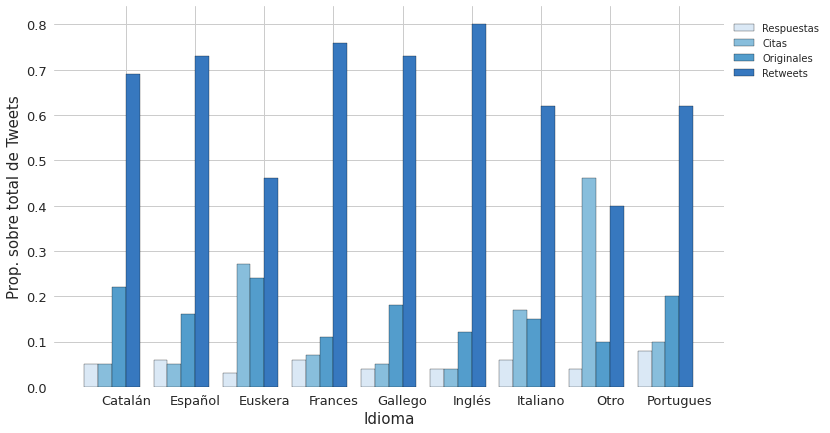

In [ ]:
fig, ax = plt.subplots(figsize=(12,7))

# width of the bars
barWidth = 0.2
 
# height of bars
org_bars = round(tweets_type_by_lang['Prop. Originales'],2)
rts_bars = round(tweets_type_by_lang['Prop. Retweets'],2)
rps_bars = round(tweets_type_by_lang['Prop. Respuestas'],2)
qts_bars = round(tweets_type_by_lang['Prop. Citas'],2)
 
# The x position of bars
r1 = np.arange(len(rps_bars))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Create reply bars
rp_rects = plt.bar(r1, rps_bars, width=barWidth, color=celeste_claro_hc, edgecolor='black', capsize=7, label='Respuestas')
# Create quote bars
qt_rects = plt.bar(r2, qts_bars, width=barWidth, color =celeste_int2_hc, edgecolor='black', capsize=7, label='Citas')
# Create original bars
or_rects = plt.bar(r3, org_bars, width=barWidth, color =celeste_int1_hc, edgecolor='black', capsize=7, label='Originales')
# Create retweet bars
rt_rects = plt.bar(r4, rts_bars, width=barWidth, color=azul_hc, edgecolor='black', capsize=7, label='Retweets')

# general layout
plt.xticks([r + barWidth + 0.3 for r in range(len(rps_bars))], tweets_type_by_lang.index, size=x_ticks_size)
plt.yticks(size=x_ticks_size)
plt.ylabel('Prop. sobre total de Tweets', fontsize=x_labels_size)
plt.xlabel('Idioma', fontsize=y_labels_size)
plt.legend(loc=(1.01,0.8))


# Show graphic
plt.show()

In [ ]:
# save figure to file
fig.savefig(os.path.join(img_path, "tweets_type_lang.png"), dpi=200, quality=95, bbox_inches="tight")

### Save table in CSV file

In [ ]:
tweets_type_by_lang.to_csv(os.path.join(data_path,'tweets_x_type_x_lang.csv'), index=False)

## Distribution of tweets by date

In [ ]:
tweets_by_date = tweets_df.groupby(['date', 'type'], as_index=False)['id'].count().\
                 sort_values('date', ascending=True)
tweets_by_date.loc[tweets_by_date['type']=='rt', 'type'] = 'Retweet'
tweets_by_date.loc[tweets_by_date['type']=='og', 'type'] = 'Original'
tweets_by_date.loc[tweets_by_date['type']=='qt', 'type'] = 'Cita'
tweets_by_date.loc[tweets_by_date['type']=='rp', 'type'] = 'Respuesta'
tweets_by_date.rename(columns={'id': 'total', 'type': 'Tipo'}, inplace=True)

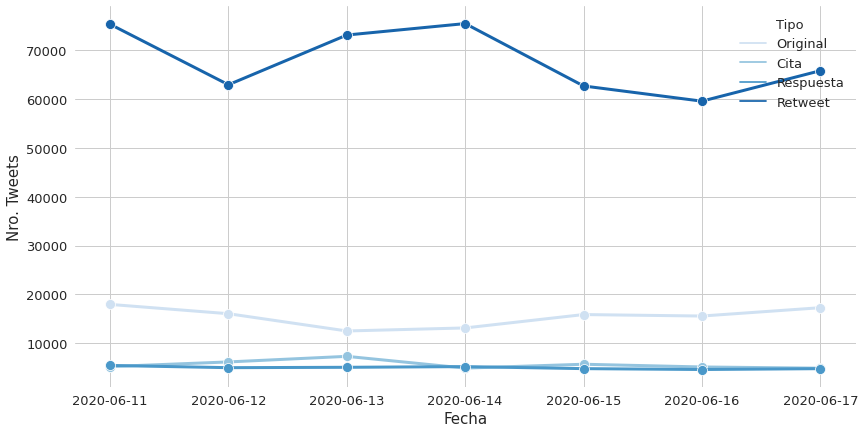

In [ ]:
plt.figure(figsize=(14,7))
fig = sns.lineplot(x=tweets_by_date['date'], y=tweets_by_date['total'], hue=tweets_by_date['Tipo'], 
                   palette='Blues', linewidth=3, sort=False, marker='o', markersize=10)
fig.set_xlabel('Fecha',fontsize=x_labels_size)
fig.set_ylabel('Nro. Tweets',fontsize=y_labels_size)
plt.xticks(size=x_ticks_size)
plt.yticks(size=y_ticks_size)
plt.legend(loc='upper right', fontsize=13)
plt.show()

In [ ]:
# save figure to file
fig.get_figure().savefig(os.path.join(img_path, "tweets_types_evolution.png"), dpi=200, quality=95, bbox_inches="tight")

In [ ]:
tweets_by_date = tweets_by_date.pivot(columns='Tipo', values='total', index='date')

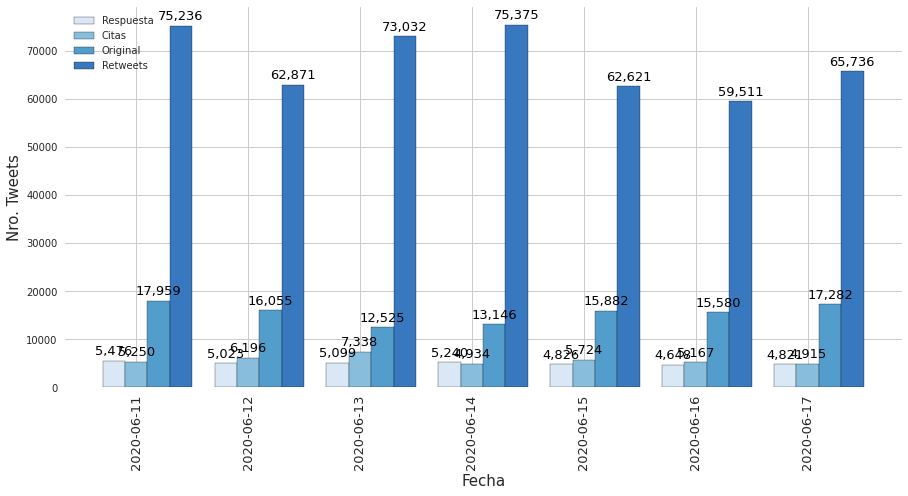

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))

# width of the bars
barWidth = 0.2
 
# height of bars
org_bars = tweets_by_date['Original']
rts_bars = tweets_by_date['Retweet']
rps_bars = tweets_by_date['Respuesta']
qts_bars = tweets_by_date['Cita']
 
# The x position of bars
r1 = np.arange(len(rps_bars))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Create reply bars
rp_rects = plt.bar(r1, rps_bars, width=barWidth, color=celeste_claro_hc, edgecolor='black', capsize=7, label='Respuesta')
# Create quote bars
qt_rects = plt.bar(r2, qts_bars, width=barWidth, color =celeste_int2_hc, edgecolor='black', capsize=7, label='Citas')
# Create original bars
or_rects = plt.bar(r3, org_bars, width=barWidth, color =celeste_int1_hc, edgecolor='black', capsize=7, label='Original')
# Create retweet bars
rt_rects = plt.bar(r4, rts_bars, width=barWidth, color=azul_hc, edgecolor='black', capsize=7, label='Retweets')

# general layout
plt.xticks([r + barWidth for r in range(len(rps_bars))], tweets_by_date.index.unique(), size=x_ticks_size, rotation=90)
plt.ylabel('Nro. Tweets', fontsize=y_labels_size)
plt.xlabel('Fecha', fontsize=x_labels_size)
plt.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:,}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=13, color='black')


autolabel(rp_rects)
autolabel(qt_rects)
autolabel(or_rects)
autolabel(rt_rects)


# Show graphic
plt.show()

In [ ]:
# save figure to file
fig.savefig(os.path.join(img_path,"tweets_types_bars.png"), dpi=200, quality=95, bbox_inches="tight")

### Save table in CSV file

In [ ]:
tweets_by_date.to_csv(os.path.join(data_path,'tweets_x_date.csv'), index=False)

## Evolution of tweet types by date and time

In [ ]:
tweets_by_date = tweets_df.groupby(['date_hour', 'type'], as_index=False)['id'].count().sort_values('date_hour', ascending=True)
tweets_by_date.loc[tweets_by_date['type']=='rt', 'type'] = 'Retweet'
tweets_by_date.loc[tweets_by_date['type']=='og', 'type'] = 'Original'
tweets_by_date.loc[tweets_by_date['type']=='qt', 'type'] = 'Cita'
tweets_by_date.loc[tweets_by_date['type']=='rp', 'type'] = 'Respuesta'
tweets_by_date.rename(columns={'id': 'total', 'type': 'Tipo'}, inplace=True)

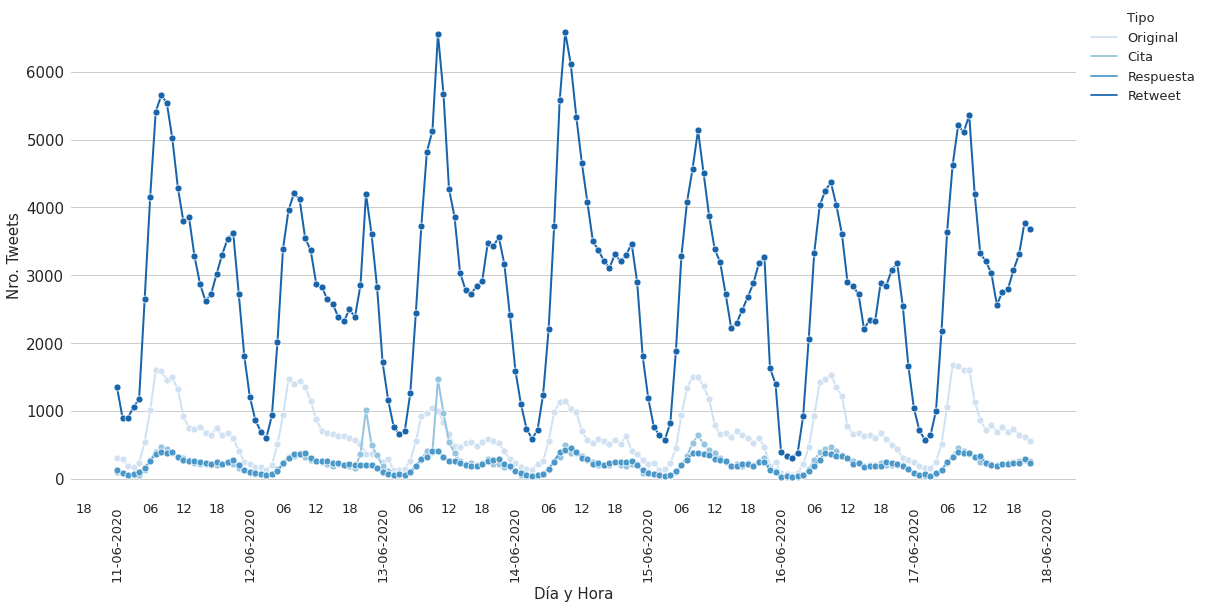

In [ ]:
plt.figure(figsize=(18,9))

fig = sns.lineplot(x=pd.to_datetime(tweets_by_date['date_hour']), y=tweets_by_date['total'], hue=tweets_by_date['Tipo'], 
                   palette='Blues', linewidth=2, sort=False, marker='o', markersize=7)
fig.set_xlabel('Día y Hora',fontsize=x_labels_size)
fig.set_ylabel('Nro. Tweets',fontsize=y_labels_size)
plt.yticks(size = 15)

# format mayor ticks every day
fig.xaxis.set_major_locator(mdates.DayLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.setp(fig.xaxis.get_majorticklabels(), rotation=90, size=x_ticks_size)

# format minor ticks every six hours
fig.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0,24,6)))
fig.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
plt.setp(fig.xaxis.get_minorticklabels(), size=y_ticks_size)

#labels = fig.get_xticklabels()
#for idx, label in enumerate(labels):
#    label_txt = label.get_text()
#    print(label_txt)
#    hour = label_txt.split()[1].split(':')[0]
#    if hour not in ['00','06','12','18']:
#        labels[idx] = ''        
#    plt.gca().set_xticklabels(labels)

fig.grid(axis='x')
plt.legend(loc=(1.01,0.8), fontsize=13)
plt.show()

In [ ]:
# save figure to file
fig.get_figure().savefig(os.path.join(img_path, "tweets_types_evolution_hours.png"), dpi=200, quality=95, bbox_inches="tight")

### Save table in CSV file

In [ ]:
tweets_by_date.to_csv(os.path.join(data_path,'tweets_x_date_x_hour.csv'), index=False)

Let's see a random sample of 1000 tweets published on 13-06

In [ ]:
filter_query = {'created_at_date': {'$eq': '2020-06-13'}, 'type': {'$ne': 'retweet'}, 'lang': 'es'}
fields_to_retrieve = {
    '_id': 0,
    'id': 1,
    'complete_text':1,
    'created_at': 1
}
data = dbm.get_tweets_reduced(filter_query,fields_to_retrieve)
sample_tweets_df = pd.DataFrame(data)

In [ ]:
sample_tweets_df['created_at'] = pd.to_datetime(sample_tweets_df['created_at'])

In [ ]:
sample_tweets_df = sample_tweets_df.sort_values('created_at', ascending=True)

In [ ]:
sample_tweets_df[sample_tweets_df.created_at.dt.hour > 6].sample(1000, random_state=42).sort_values('created_at').to_csv(os.path.join(data_path,'sample_1306.csv'), index=False)

## Distribution of tweets by day of the week, including weekend, and time

In [ ]:
if 'day_week' not in list(tweets_df.columns):
    tweets_df['day_week'] = tweets_df['created_at'].dt.strftime('%A %d-%m-%Y')

In [ ]:
def put_name_week_day_in_spanish(day_week):
    day, date = day_week.split()
    if day == 'Sunday':
        es_day = 'Domingo'
    elif day == 'Monday':
        es_day = 'Lunes'
    elif day == 'Tuesday':
        es_day = 'Martes'
    elif day == 'Wednesday':
        es_day = 'Miércoles'
    elif day == 'Thursday':
        es_day = 'Jueves'
    elif day == 'Friday':
        es_day = 'Viernes'
    else:
        es_day = 'Sábado'
    return es_day + ' ' + date

In [ ]:
tweets_df.loc[:,'day_week'] = tweets_df.loc[:,'day_week'].apply(put_name_week_day_in_spanish)

In [ ]:
tweets_df['hour'] = tweets_df['created_at'].dt.strftime('%H')

In [ ]:
tweets_by_day_hour = tweets_df.groupby(['day_week','hour'], as_index=False)['id'].count().sort_values('day_week', ascending=True)
tweets_by_day_hour.rename(columns={'id': 'total'}, inplace=True)

In [ ]:
tweets_by_day_hour = tweets_by_day_hour.pivot('day_week','hour','total')

In [ ]:
week_days_order = ['Jueves','Viernes','Sábado','Domingo','Lunes','Martes','Miércoles']
reindex_order = [None]*7
for idx in tweets_by_day_hour.index:
    for wd_idx, week_day in enumerate(week_days_order):
        if week_day in idx:
            reindex_order[wd_idx] = idx

In [ ]:
tweets_by_day_hour = tweets_by_day_hour.reindex(reindex_order)

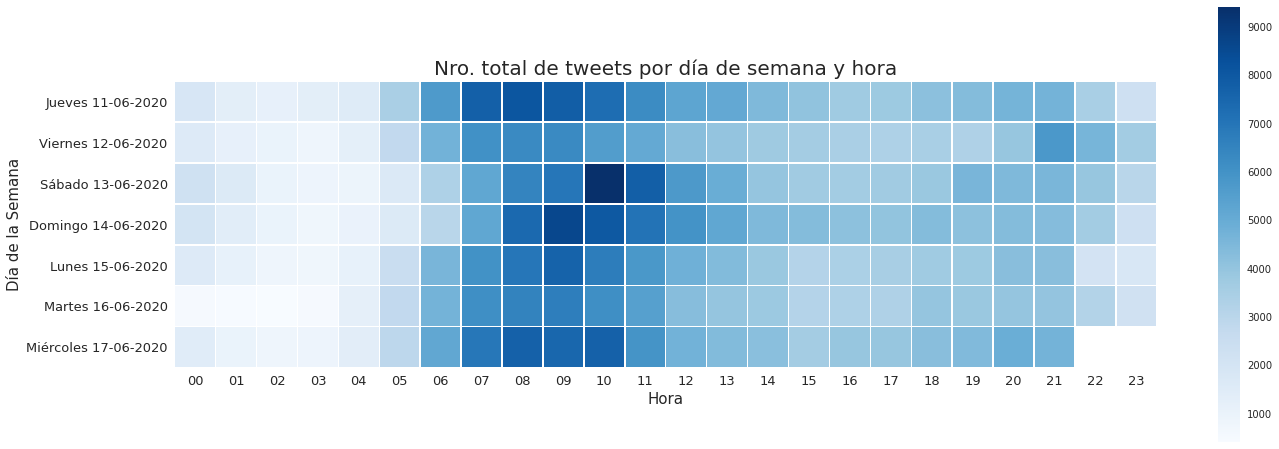

In [ ]:
plt.figure(figsize=(22,8))
fig = sns.heatmap(tweets_by_day_hour, linewidths=.5, cmap="Blues", square="True")
fig.set_xlabel('Hora',fontsize=x_labels_size)
fig.set_ylabel('Día de la Semana',fontsize=y_labels_size)
plt.xticks(size=x_ticks_size)
plt.yticks(size=y_ticks_size)
plt.title('Nro. total de tweets por día de semana y hora', size=20)
plt.show()

In [ ]:
# save figure to file
fig.get_figure().savefig(os.path.join(img_path, "tweets_weekday_hours.png"), dpi=200, quality=95, bbox_inches="tight")

### Save table in CSV file

In [ ]:
tweets_by_day_hour.to_csv(os.path.join(data_path,'tweets_x_weekday_x_hour.csv'), index=False)

## Distribution of tweets by day of the week, including weekend, time, and type

In [ ]:
if 'day_week' not in list(tweets_df.columns):
    tweets_df['day_week'] = tweets_df['created_at'].dt.strftime('%A %d-%m-%Y')

In [ ]:
if 'hour' not in list(tweets_df.columns):
    tweets_df['hour'] = tweets_df['created_at'].dt.strftime('%H')

In [ ]:
tweets_by_day_hour_type = tweets_df.groupby(['day_week','hour','type'], as_index=False)['id'].count().sort_values(['day_week','hour','type'], ascending=True)
tweets_by_day_hour_type.loc[tweets_by_day_hour_type['type']=='rt', 'type'] = 'Retweet'
tweets_by_day_hour_type.loc[tweets_by_day_hour_type['type']=='og', 'type'] = 'Original'
tweets_by_day_hour_type.loc[tweets_by_day_hour_type['type']=='qt', 'type'] = 'Cita'
tweets_by_day_hour_type.loc[tweets_by_day_hour_type['type']=='rp', 'type'] = 'Respuesta'
tweets_by_day_hour_type.rename(columns={'id': 'total', 'type': 'Tipo'}, inplace=True)

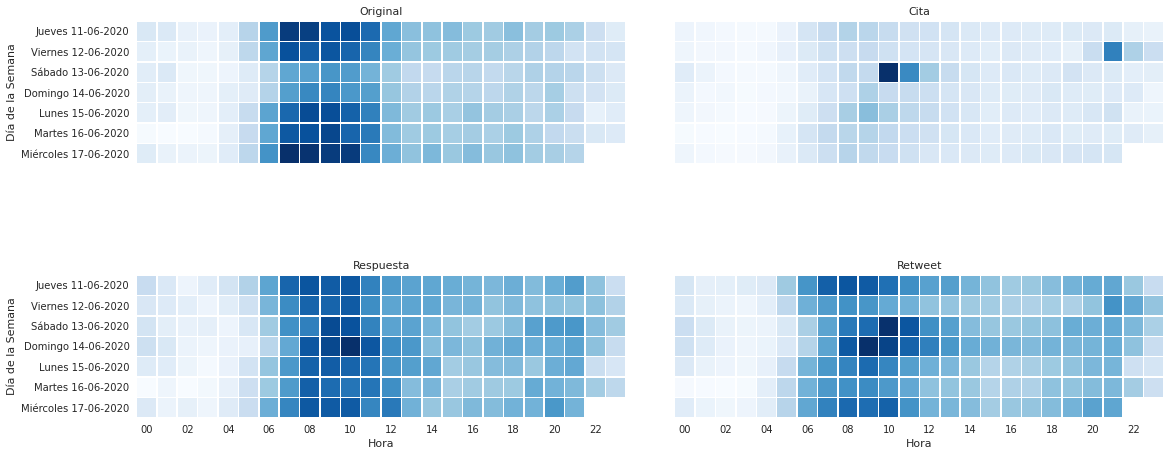

In [ ]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2])
    d = d.reindex(reindex_order)
    sns.heatmap(d, **kwargs)

fig= sns.FacetGrid(tweets_by_day_hour_type, col='Tipo', col_wrap=2)
fig.map_dataframe(draw_heatmap, 'hour', 'day_week', 'total', cbar=False, square=True, linewidths=.5, cmap="Blues")
fig.set_axis_labels("Hora", "Día de la Semana")
fig.set_titles("{col_name}")
# get figure background color
facecolor=plt.gcf().get_facecolor()
for ax in fig.axes.flat:
    # set aspect of all axis
    ax.set_aspect('equal','box')

fig.fig.set_figwidth(22)
fig.fig.set_figheight(10)
    
plt.show()

In [ ]:
# save figure to file
fig.savefig(os.path.join(img_path, "tweets_weekday_hours_type.png"), dpi=200, quality=95, bbox_inches="tight")

### Save table in CSV file

In [ ]:
tweets_by_day_hour_type.to_csv(os.path.join(data_path,'tweets_x_weekday_x_hour_x_type.csv'), index=False)

## Distribution of unique users by date

In [ ]:
users_by_date = tweets_df.groupby(['date'])['user_screen_name'].nunique().reset_index().sort_values('date', ascending=True)
users_by_date.rename(columns={'user_screen_name': 'unique_users'}, inplace=True)

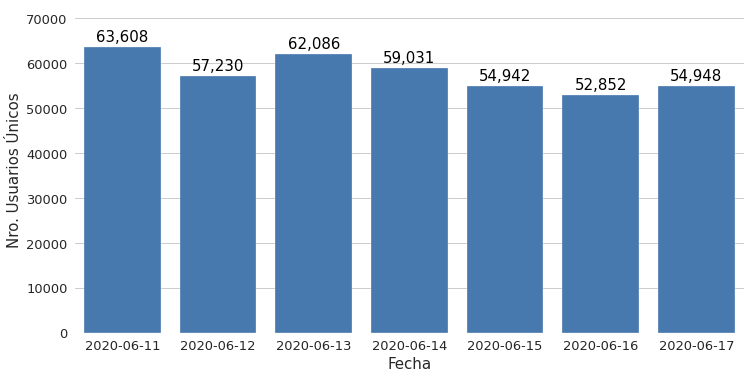

In [ ]:
plt.figure(figsize=(12,6))
fig = sns.barplot(x='date', y='unique_users', data=users_by_date, color=azul_hc)
fig.set_xlabel('Fecha',fontsize=x_labels_size)
fig.set_ylabel('Nro. Usuarios Únicos',fontsize=y_labels_size)
plt.yticks(size=x_ticks_size)
plt.xticks(size=y_ticks_size)
ax=fig
# Annotate bars
for p in ax.patches:
    ax.annotate("{0:,}".format(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=15, color='black', xytext=(0, 10),
                 textcoords='offset points')
_ = fig.set_ylim(0,max(users_by_date['unique_users'])+9000) #To make space for the annotations
plt.show()

In [ ]:
# save figure to file
fig.get_figure().savefig(os.path.join(img_path, "users_date.png"), dpi=200, quality=95, bbox_inches="tight")

### Save table in CSV file

In [ ]:
users_by_date.to_csv(os.path.join(data_path,'users_x_date.csv'), index=False)

## Distribution of unique users by date and tweet types

In [ ]:
users_by_date = tweets_df.groupby(['date', 'type'])['user_screen_name'].nunique().reset_index().sort_values('date', ascending=True)
users_by_date.loc[users_by_date['type']=='rt', 'type'] = 'Retweet'
users_by_date.loc[users_by_date['type']=='og', 'type'] = 'Original'
users_by_date.loc[users_by_date['type']=='qt', 'type'] = 'Cita'
users_by_date.loc[users_by_date['type']=='rp', 'type'] = 'Respuesta'
users_by_date.rename(columns={'user_screen_name': 'unique_users', 'type': 'Tipo'}, inplace=True)

In [ ]:
users_by_date = users_by_date.pivot(columns='Tipo', values='unique_users', index='date')

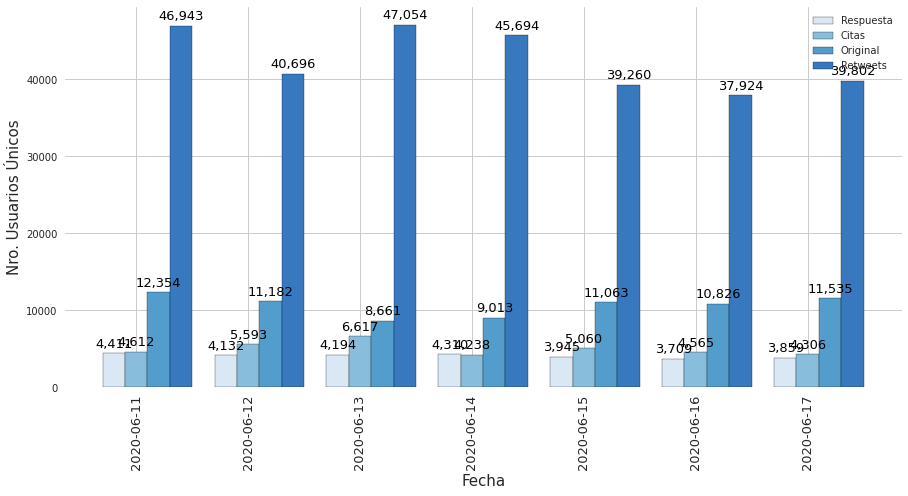

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))

# width of the bars
barWidth = 0.2
 
# height of bars
org_bars = users_by_date['Original']
rts_bars = users_by_date['Retweet']
rps_bars = users_by_date['Respuesta']
qts_bars = users_by_date['Cita']
 
# The x position of bars
r1 = np.arange(len(rps_bars))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Create reply bars
rp_rects = plt.bar(r1, rps_bars, width=barWidth, color=celeste_claro_hc, edgecolor='black', capsize=7, label='Respuesta')
# Create quote bars
qt_rects = plt.bar(r2, qts_bars, width=barWidth, color =celeste_int2_hc, edgecolor='black', capsize=7, label='Citas')
# Create original bars
or_rects = plt.bar(r3, org_bars, width=barWidth, color =celeste_int1_hc, edgecolor='black', capsize=7, label='Original')
# Create retweet bars
rt_rects = plt.bar(r4, rts_bars, width=barWidth, color=azul_hc, edgecolor='black', capsize=7, label='Retweets')

# general layout
plt.xticks([r + barWidth for r in range(len(rps_bars))], users_by_date.index.unique(), size=x_ticks_size, rotation=90)
plt.ylabel('Nro. Usuarios Únicos', fontsize=x_labels_size)
plt.xlabel('Fecha', fontsize=y_labels_size)
plt.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:,}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=13, color='black')


autolabel(rp_rects)
autolabel(qt_rects)
autolabel(or_rects)
autolabel(rt_rects)


# Show graphic
plt.show()

In [ ]:
# save figure to file
fig.savefig(os.path.join(img_path, "users_date_type.png"), dpi=200, quality=95, bbox_inches="tight")

### Save table in CSV file

In [ ]:
users_by_date.to_csv(os.path.join(data_path,'users_x_date_x_type.csv'), index=False)

## Distribution of unique users by day of the week, including weekend, and time

In [ ]:
if 'day_week' not in list(tweets_df.columns):
    tweets_df['day_week'] = tweets_df['created_at'].dt.strftime('%A %d-%m-%Y')

In [ ]:
if 'hour' not in list(tweets_df.columns):
    tweets_df['hour'] = tweets_df['created_at'].dt.strftime('%H')

In [ ]:
users_by_day_hour = tweets_df.groupby(['day_week','hour'])['user_screen_name'].nunique().reset_index().sort_values('day_week', ascending=True)
users_by_day_hour.rename(columns={'user_screen_name': 'unique_users'}, inplace=True)

In [ ]:
users_by_day_hour = users_by_day_hour.pivot('day_week','hour','unique_users')

In [ ]:
users_by_day_hour = users_by_day_hour.reindex(reindex_order)

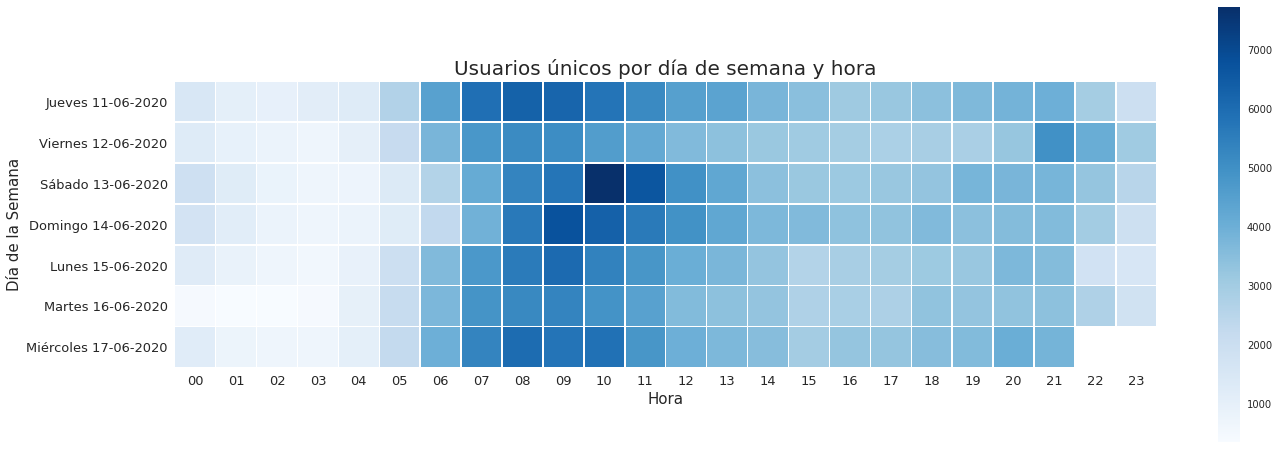

In [ ]:
plt.figure(figsize=(22,8))
fig = sns.heatmap(users_by_day_hour, linewidths=.5, cmap="Blues", square="True")
fig.set_xlabel('Hora',fontsize=x_labels_size)
fig.set_ylabel('Día de la Semana',fontsize=y_labels_size)
plt.xticks(size=x_ticks_size)
plt.yticks(size=y_ticks_size)
plt.title('Usuarios únicos por día de semana y hora', size=20)
plt.show()

In [ ]:
# save figure to file
fig.get_figure().savefig(os.path.join(img_path, "users_day_hour.png"), dpi=200, quality=95, bbox_inches="tight")

### Save table in CSV file

In [ ]:
users_by_day_hour.to_csv(os.path.join(data_path,'users_x_weekday_x_hour.csv'), index=False)

## Sentiment Analysis

In [ ]:
thresholds = {'low': -0.1, 'high': 0.1}

In [ ]:
sa_df = tweets_df.loc[:, ['id', 'date', 'sentiment']]
sa_df.loc[:, 'sentiment'] = pd.to_numeric(sa_df.loc[:, 'sentiment'])

#### Score

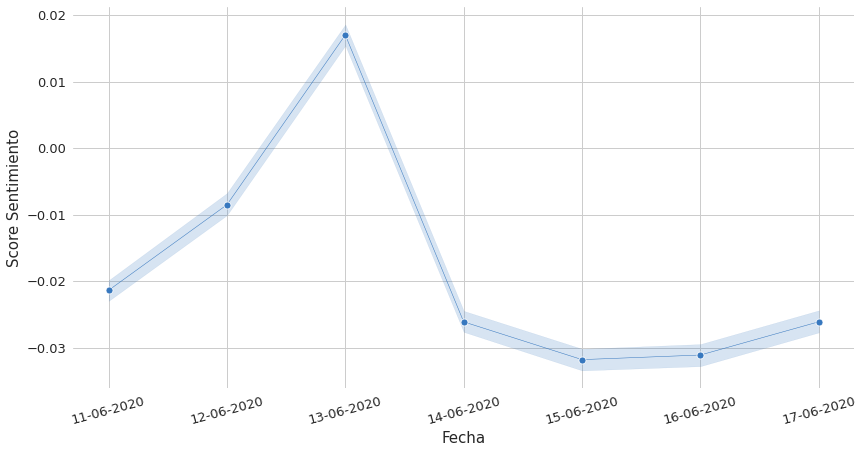

In [ ]:
plt.figure(figsize=(14,7))
fig = sns.lineplot(x=sa_df['date'], y=sa_df['sentiment'], linewidth=0.5, marker='o', color=azul_hc)
fig.set_xlabel('Fecha',fontsize=x_labels_size)
fig.set_ylabel('Score Sentimiento',fontsize=y_labels_size)
plt.yticks(size=y_ticks_size)
#plt.ylim((-1,1))
fig.xaxis.set_major_locator(mdates.DayLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.setp(fig.xaxis.get_majorticklabels(), rotation=15, size=x_ticks_size)
plt.show()

In [ ]:
# save figure to file
fig.get_figure().savefig(os.path.join(img_path, "tweets_sentiment_score_evolution_con_rts.png"), dpi=200, quality=95, bbox_inches="tight")

#### Save table in CSV file

In [ ]:
sa_df[['date','sentiment']].to_csv(os.path.join(data_path,'tweets_sentiment_score_x_date_con_rts.csv'), index=False)

#### Polarity

In [ ]:
sa_df.loc[:, 'sentiment_label'] = np.where(sa_df.loc[:, 'sentiment'] > thresholds['high'], 'positivo', np.where(sa_df.loc[:, 'sentiment'] < thresholds['low'], 'negativo', 'neutral'))

In [ ]:
tweets_by_group = sa_df.groupby(['date', 'sentiment_label'], as_index=False)['id'].count().sort_values('date', ascending=True)
tweets_by_group.rename(columns={'id': 'id', 'sentiment_label': 'Sentimiento'}, inplace=True)

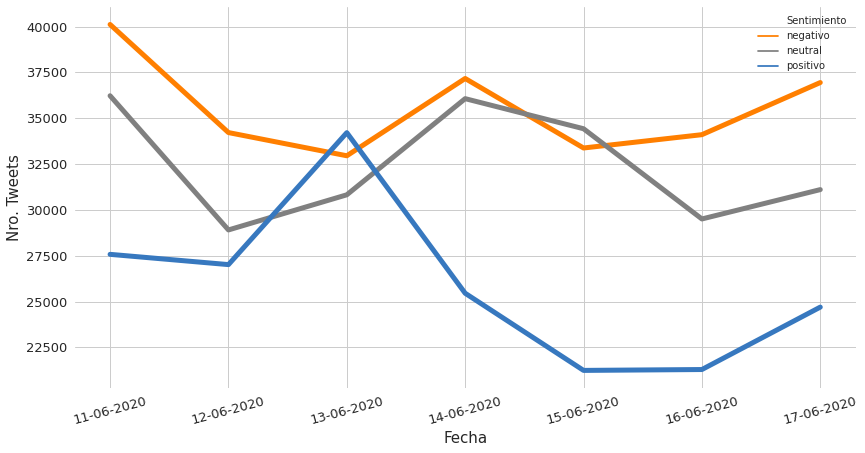

In [ ]:
plt.figure(figsize=(14,7))
fig = sns.lineplot(x=tweets_by_group['date'], y=tweets_by_group['id'], hue=tweets_by_group['Sentimiento'], \
                   linewidth=5, sort=False, palette=[naranja_hc, gris, azul_hc])
fig.set_xlabel('Fecha',fontsize=x_labels_size)
fig.set_ylabel('Nro. Tweets',fontsize=y_labels_size)
plt.yticks(size=y_ticks_size)
fig.xaxis.set_major_locator(mdates.DayLocator())
fig.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.setp(fig.xaxis.get_majorticklabels(), rotation=15, size=x_ticks_size)
plt.show()

In [ ]:
# save figure to file
fig.get_figure().savefig(os.path.join(img_path, "tweets_sentiment_evolution_con_rts.png"), dpi=200, quality=95, bbox_inches="tight")

#### Polarity by date (including RTs)

In [ ]:
tweets_sentiment_by_date = tweets_by_group.pivot(columns='Sentimiento', values='id', index='date')

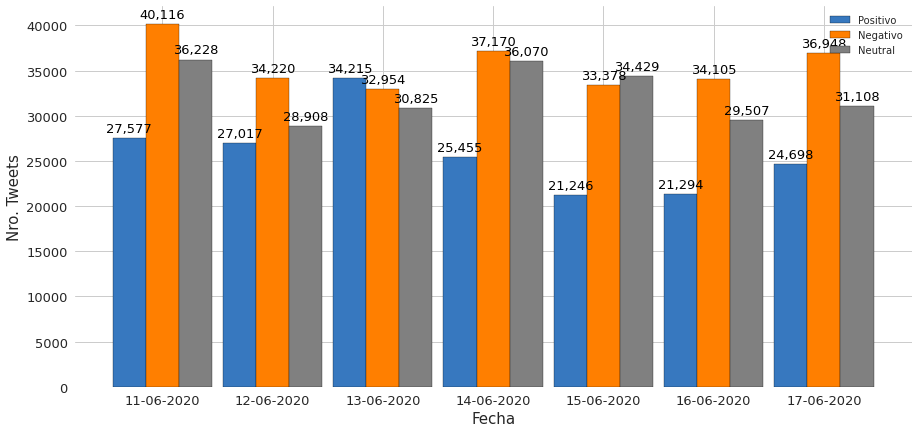

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))

# width of the bars
barWidth = 0.3
 
# height of bars
pos_bars = tweets_sentiment_by_date['positivo']
neg_bars = tweets_sentiment_by_date['negativo']
neu_bars = tweets_sentiment_by_date['neutral']

# dates
xaxis_values = [date.strftime('%d-%m-%Y') for date in tweets_sentiment_by_date.index.unique()]

# The x position of bars
r1 = np.arange(len(pos_bars))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create positive bars
pos_rects = plt.bar(r1, pos_bars, width=barWidth, color=azul_hc, edgecolor='black', capsize=7, label='Positivo')
# Create negative bars
neg_rects = plt.bar(r2, neg_bars, width=barWidth, color=naranja_hc, edgecolor='black', capsize=7, label='Negativo')
# Create neutral bars
neu_rects = plt.bar(r3, neu_bars, width=barWidth, color=gris, edgecolor='black', capsize=7, label='Neutral')

# general layout
plt.xticks([r + barWidth for r in range(len(pos_bars))], xaxis_values, size=x_ticks_size)
plt.ylabel('Nro. Tweets', fontsize=x_labels_size)
plt.xlabel('Fecha', fontsize=x_labels_size)
plt.yticks(size=y_ticks_size)
plt.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:,}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=13, color='black')

autolabel(pos_rects)
autolabel(neg_rects)
autolabel(neu_rects)

# Show graphic
plt.show()

In [ ]:
# save figure to file
fig.savefig(os.path.join(img_path,"tweets_sentiment_evolution_bars_con_rts.png"), dpi=200, quality=95, bbox_inches="tight")

In [ ]:
dist_sentiments = sa_df.groupby('sentiment_label', as_index=False).size().to_frame(name='count').reset_index()

In [ ]:
dist_sentiments['prop'] = dist_sentiments['count']/sa_df.shape[0]

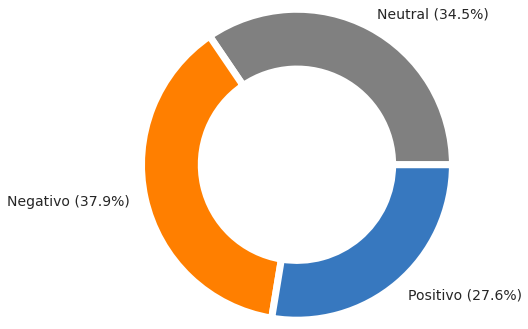

In [ ]:
neutral = round(dist_sentiments.loc[dist_sentiments['sentiment_label']=='neutral','prop'].values[0]*100,1)
positive = round(dist_sentiments.loc[dist_sentiments['sentiment_label']=='positivo','prop'].values[0]*100,1)
negative = round(dist_sentiments.loc[dist_sentiments['sentiment_label']=='negativo','prop'].values[0]*100,1)

values = [neutral,negative,positive]

group_names=['Neutral ({}%)'.format(str(neutral)), 
             'Negativo ({}%)'.format(str(negative)), 
             'Positivo ({}%)'.format(str(positive))]
group_size=values
fig, ax = plt.subplots()
ax.axis('equal')
pie, _ = ax.pie(group_size, radius=1.3, labels=group_names, 
                wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
                colors=[gris, naranja_hc, azul_hc],
                textprops={'fontsize': 14})
plt.setp(pie, width=0.5, edgecolor='white')
plt.show()

In [ ]:
# save figure to file
fig.savefig(os.path.join(img_path, "tweets_sentiments_donut_con_rts.png"), dpi=200, quality=95, bbox_inches="tight")

#### Save into CSV file

In [ ]:
tweets_by_group.to_csv(os.path.join(data_path,'tweets_sentiment_polarity_x_date_con_rts.csv'), index=False)

## Sentiment analysis by day of the week, including weekend, and time

In [ ]:
if 'day_week' not in list(tweets_df.columns):
    tweets_df['day_week'] = tweets_df['created_at'].dt.strftime('%A %d-%m-%Y')

In [ ]:
def put_name_week_day_in_spanish(day_week):
    day, date = day_week.split()
    if day == 'Sunday':
        es_day = 'Domingo'
    elif day == 'Monday':
        es_day = 'Lunes'
    elif day == 'Tuesday':
        es_day = 'Martes'
    elif day == 'Wednesday':
        es_day = 'Miércoles'
    elif day == 'Thursday':
        es_day = 'Jueves'
    elif day == 'Friday':
        es_day = 'Viernes'
    else:
        es_day = 'Sábado'
    return es_day + ' ' + date

In [ ]:
if 'hour' not in list(tweets_df.columns):
    tweets_df['hour'] = tweets_df['created_at'].dt.strftime('%H')

In [ ]:
sentiments_by_day_hour = tweets_df.groupby(['day_week','hour'])['sentiment'].mean().reset_index().sort_values('day_week', ascending=True)

In [ ]:
sentiments_by_day_hour = sentiments_by_day_hour.pivot('day_week','hour','sentiment')

In [ ]:
week_days_order = ['Jueves','Viernes','Sábado','Domingo','Lunes','Martes','Miércoles']
reindex_order = [None]*7
for idx in sentiments_by_day_hour.index:
    for wd_idx, week_day in enumerate(week_days_order):
        if week_day in idx:
            reindex_order[wd_idx] = idx

In [ ]:
sentiments_by_day_hour = sentiments_by_day_hour.reindex(reindex_order)

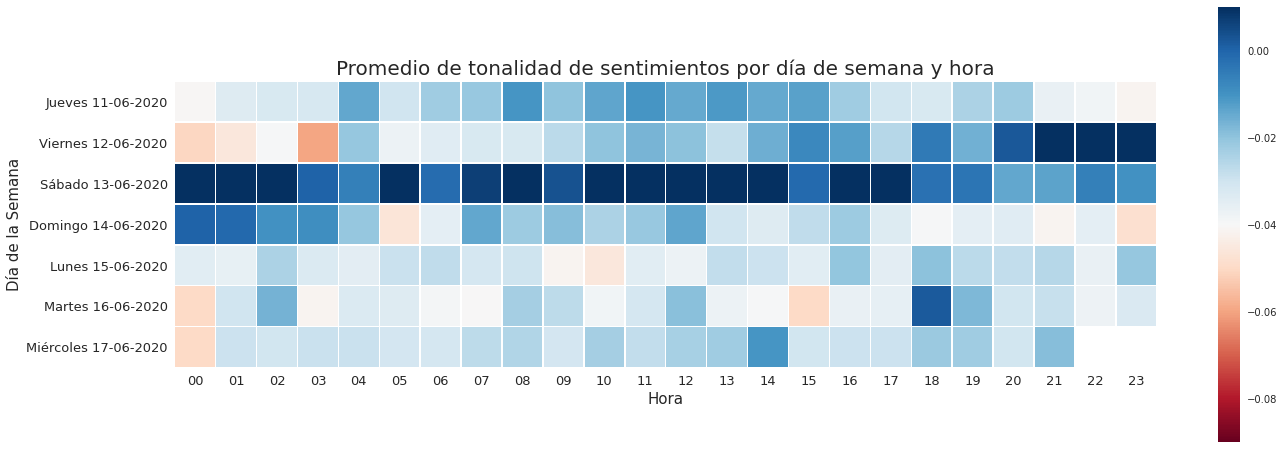

In [ ]:
plt.figure(figsize=(22,8))
fig = sns.heatmap(sentiments_by_day_hour, linewidths=.5, cmap="RdBu", square="True", vmin=-0.09, vmax=0.01)
fig.set_xlabel('Hora',fontsize=x_labels_size)
fig.set_ylabel('Día de la Semana',fontsize=y_labels_size)
plt.xticks(size=x_ticks_size)
plt.yticks(size=y_ticks_size)
plt.title('Promedio de tonalidad de sentimientos por día de semana y hora', size=20)
plt.show()

In [ ]:
# save figure to file
fig.get_figure().savefig(os.path.join(img_path, "sentiments_day_hour_con_rango_fijo.png"), dpi=200, quality=95, bbox_inches="tight")

### Save table in CSV file

In [ ]:
sentiments_by_day_hour.to_csv(os.path.join(data_path,'sentiments_x_weekday_x_hour.csv'))

## Sentiment comparison between current and last week

In [ ]:
weeks = [
    {'dir': '5_2304290420', 'name': '23/04-29/04'},
    {'dir': '6_3004060520', 'name': '30/04-06/05'},
    {'dir': '7_0705130520', 'name': '07/05-13/05'},
    {'dir': '8_1405200520', 'name': '14/05-20/05'},
    {'dir': '9_2105270520', 'name': '21/05-27/05'},
    {'dir': '10_2805030620', 'name': '28/05-03/06'},
    {'dir': '11_0406100620', 'name': '04/06-10/06'},
    {'dir': '12_1106170620', 'name': '11/06-17/06'}
]

In [ ]:
sentiment_weeks_df = pd.DataFrame()
sentiments = ['negativo', 'positivo', 'neutral']
for week in weeks:
    dataset_file_name = os.path.join(report_dir, week['dir'], 'data', 'tweets_sentiment_polarity_x_date_con_rts.csv')
    current_week_df = pd.read_csv(dataset_file_name)
    current_week_sentiment_df = pd.DataFrame.from_dict({'sentimiento': sentiments, 'total':[0,0,0], 'percentage': [0.,0.,0.]})
    for sentiment in sentiments:
        current_week_sentiment_df.loc[current_week_sentiment_df['sentimiento']==sentiment,'total'] = \
            current_week_df.loc[current_week_df['Sentimiento']==sentiment,'id'].sum()
        current_week_sentiment_df.loc[current_week_sentiment_df['sentimiento']==sentiment,'percentage'] = \
            round(100*(current_week_df.loc[current_week_df['Sentimiento']==sentiment,'id'].sum()/current_week_df['id'].sum()),2)
    current_week_sentiment_df['week'] = week['name']
    sentiment_weeks_df = sentiment_weeks_df.append(current_week_sentiment_df)

In [ ]:
sentiment_weeks_df

,sentimiento,total,percentage,week
0,negativo,295548,38.79,23/04-29/04
1,positivo,207795,27.28,23/04-29/04
2,neutral,258496,33.93,23/04-29/04
0,negativo,293049,39.82,30/04-06/05
1,positivo,193325,26.27,30/04-06/05
2,neutral,249534,33.91,30/04-06/05
0,negativo,260392,40.31,07/05-13/05
1,positivo,163829,25.36,07/05-13/05
2,neutral,221749,34.33,07/05-13/05
0,negativo,292790,42.16,14/05-20/05


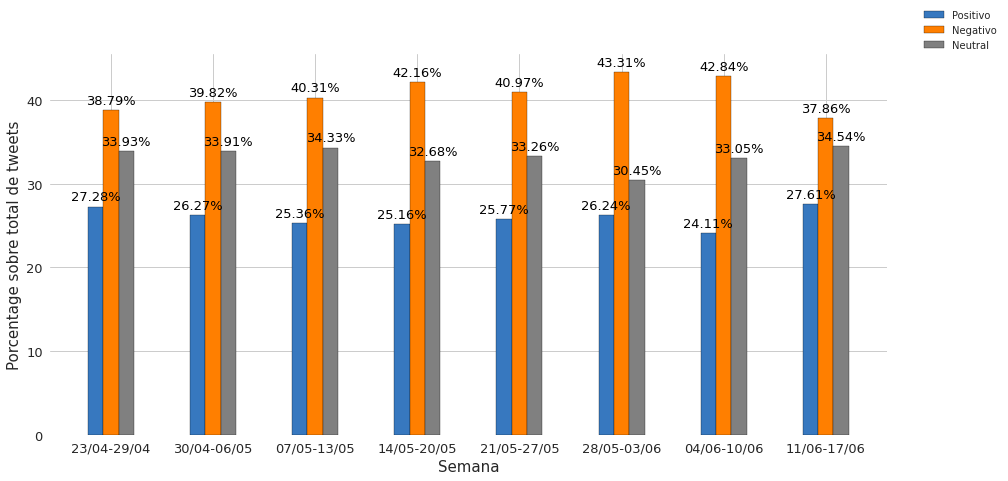

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))

# width of the bars
barWidth = 0.15
 
# height of bars
pos_bars = sentiment_weeks_df.loc[sentiment_weeks_df['sentimiento']=='positivo','total'].values
per_pos_bars = sentiment_weeks_df.loc[sentiment_weeks_df['sentimiento']=='positivo','percentage'].values
neg_bars = sentiment_weeks_df.loc[sentiment_weeks_df['sentimiento']=='negativo','total'].values
per_neg_bars = sentiment_weeks_df.loc[sentiment_weeks_df['sentimiento']=='negativo','percentage'].values
neu_bars = sentiment_weeks_df.loc[sentiment_weeks_df['sentimiento']=='neutral','total'].values
per_neu_bars = sentiment_weeks_df.loc[sentiment_weeks_df['sentimiento']=='neutral','percentage'].values

# The x position of bars
r1 = np.arange(len(pos_bars))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create positive bars
pos_rects = plt.bar(r1, per_pos_bars, width=barWidth, color=azul_hc, edgecolor='black', capsize=7, label='Positivo')
# Create negative bars
neg_rects = plt.bar(r2, per_neg_bars, width=barWidth, color=naranja_hc, edgecolor='black', capsize=7, label='Negativo')
# Create neutral bars
neu_rects = plt.bar(r3, per_neu_bars, width=barWidth, color=gris, edgecolor='black', capsize=7, label='Neutral')

# general layout
plt.xticks([r + barWidth for r in range(len(pos_bars))], sentiment_weeks_df['week'].unique(), size=x_ticks_size)
plt.ylabel('Porcentage sobre total de tweets', fontsize=x_labels_size)
plt.xlabel('Semana', fontsize=x_labels_size)
plt.yticks(size=y_ticks_size)
plt.legend(loc=(1.04,1))

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for idx, rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate('{0:,}%'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=13, color='black')

autolabel(pos_rects)
autolabel(neg_rects)
autolabel(neu_rects)

# Show graphic
plt.show()

In [ ]:
# save figure to file
fig.savefig(os.path.join(img_path, "sentiments_dist_by_week.png"), dpi=200, quality=95, bbox_inches="tight")